In [1]:
import topospam as topospam
from mesh_methods import *

%matplotlib inline
repo_path=topospam.set_repo_path('..')

Success: The path '..' contains the TopoSPAM repository.


In [2]:
mesh_refine_factor = 30
output_pickle = "./meshes/sphere_single_layer.pkl"
output_file = f"./meshes/sphere_single_layer.ply"
try:
    [sphere_balls_df, sphere_edges_df, sphere_cells_df] = pickle.load(open(output_pickle, "rb"))
except:
    [sphere_balls_df, sphere_edges_df, sphere_cells_df] = get_meshzoo_icosa_sphere(refine_factor=mesh_refine_factor,
                                                                                   output_pickle=output_pickle,
                                                                                   output_file=output_file
                                                                                   )

In [3]:
thickness = 0.1
angle_of_rotation = 0.1
theta_max = 0.8662
theta_DV = 0.1931 #set 0.1931 as measured from data #set 3.14 if throughout you want DV boundary #set 0 if no DV boundary
R = 1

In [4]:
output_dir = "my_meshes"
os.makedirs(output_dir, exist_ok=True)

output_pickle = f"{output_dir}/IcoSph_mesh_wo_basis_vectors_refine_factor_{mesh_refine_factor}_thickness_{thickness}_angle_of_rotation_{angle_of_rotation}_theta_max_{theta_max}.pkl"
output_file = f"{output_dir}/IcoSph_mesh_wo_basis_vectors_refine_factor_{mesh_refine_factor}_thickness_{thickness}_angle_of_rotation_{angle_of_rotation}_theta_max_{theta_max}.vtk"
try:
    [balls_df, springs_df] = pickle.load(open(output_pickle,"rb"))
except:
    thickness_polynomial_coeffs = np.array([1])*thickness
    thickness_polynomial_obj = np.poly1d(thickness_polynomial_coeffs)

    [balls_df, springs_df] = add_thickness_to_mesh(v_df = sphere_balls_df[['x', 'y', 'z']], edges_df = sphere_edges_df, #cells_df = cells_df,
                                                               thickness_polynomial_obj = thickness_polynomial_obj,
                                                               rotate_mesh_bool=True, angle_of_rotation = angle_of_rotation,
                                                               crop_mesh_bool=True, theta_max=theta_max,
                                                               output_pickle = output_pickle, 
                                                               output_vtk = output_file,
                                                              )

In [5]:
#add basis vectors to mesh
output_pickle = f"{output_dir}/IcoSph_mesh_w_basis_vectors_refine_factor_{mesh_refine_factor}_thickness_{thickness}_angle_of_rotation_{angle_of_rotation}_theta_max_{theta_max}_theta_DV_{theta_DV}.pkl"
try:
    [balls_df, springs_df] = pickle.load(open(output_pickle,"rb"))
except:
    #add basis vectors
    [balls_df, springs_df] = add_basis_vectors_to_Sph(balls_df, springs_df, theta_DV=theta_DV)
    #save
    pickle.dump([balls_df,springs_df], open(output_pickle, 'wb'))
    

In [6]:
#modify thickness
#we can modify the thicknes off the mesh if we want
thickness = 0.2
bottom_ind = np.arange(int(len(balls_df)/2)) #bottom_index
top_ind = bottom_ind + len(bottom_ind)
balls_df.loc[bottom_ind,["x","y","z"]] =  balls_df.loc[top_ind, ["x","y","z"]].values - (thickness*balls_df.loc[top_ind, ["e_h_x","e_h_y","e_h_z"]]).values
springs_df = update_springs(springs_df, balls_df[['x', 'y', 'z']])
#save mesh
#pickle.dump([balls_df, springs_df], open(dirname+'runfiles/init_mesh.pickle', 'wb'))


# Visualization
Top View

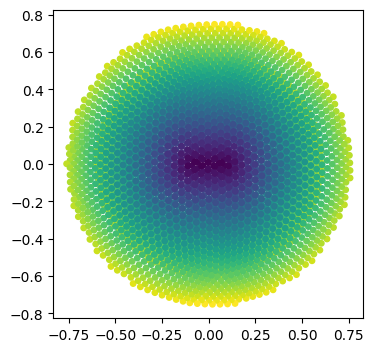

In [7]:
%matplotlib inline
fig,ax = plt.subplots(figsize = (4,4))
_=ax.scatter(balls_df["x"], balls_df["y"], s = 15, c = balls_df["pathlength_scaled"])
#plotting the DV boundary
#_=ax.axvline(x = R*np.sin(theta_DV/2), color = "black", linewidth = 5)
#_=ax.axvline(x = -R*np.sin(theta_DV/2), color = "black", linewidth = 5)
#ax.axhline(y = 0, color = "black", linewidth = 5)
_=ax.axis("equal")

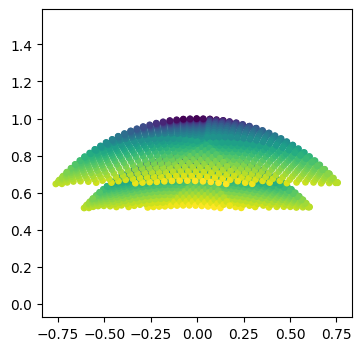

In [8]:
%matplotlib inline
fig,ax = plt.subplots(figsize = (4,4))
balls_df_crosssection = balls_df[balls_df["y"]>0]
_=ax.scatter(balls_df_crosssection["x"], balls_df_crosssection["z"], s = 15, c = balls_df_crosssection["pathlength_scaled"])
#plotting the DV boundary
#_=ax.axvline(x = R*np.sin(theta_DV/2), color = "black", linewidth = 5)
#_=ax.axvline(x = -R*np.sin(theta_DV/2), color = "black", linewidth = 5)
#ax.axhline(y = 0, color = "black", linewidth = 5)
_=ax.axis("equal")

We can use pyvista to visualize somethings like the basis vectors. The package is also useful for computing quantities like the Gaussian and Mean curvatures.

In [9]:
#extract just one layer from the thick mesh
[top_balls, top_springs] = extract_thin_mesh(balls_df, springs_df, which = "top", reindex = True)
#convert to Pyvista mesh
mesh = dfToPyvista(top_balls, top_springs)
#add basis vectors
mesh["e_h"] = top_balls[["e_h_x", "e_h_y", "e_h_z",]]
mesh["e_R"] = top_balls[[ "e_R_x", "e_R_y", "e_R_z",]]
mesh["e_phi"] = top_balls[["e_phi_x", "e_phi_y", "e_phi_z",]]
#scalar : normalized pathlength from the center
mesh["pathlength_scaled"] = top_balls["pathlength_scaled"]
#if particle in DV boundary then DV_bool = 1 otherwise 0
mesh["DV_bool"] = top_balls["DV_bool"]
#
mesh["gauss_curv"] = mesh.curvature(curv_type="gaussian")
mesh["mean_curv"] = mesh.curvature(curv_type="mean")

/Users/absingh/git/topospam/Topo_env/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


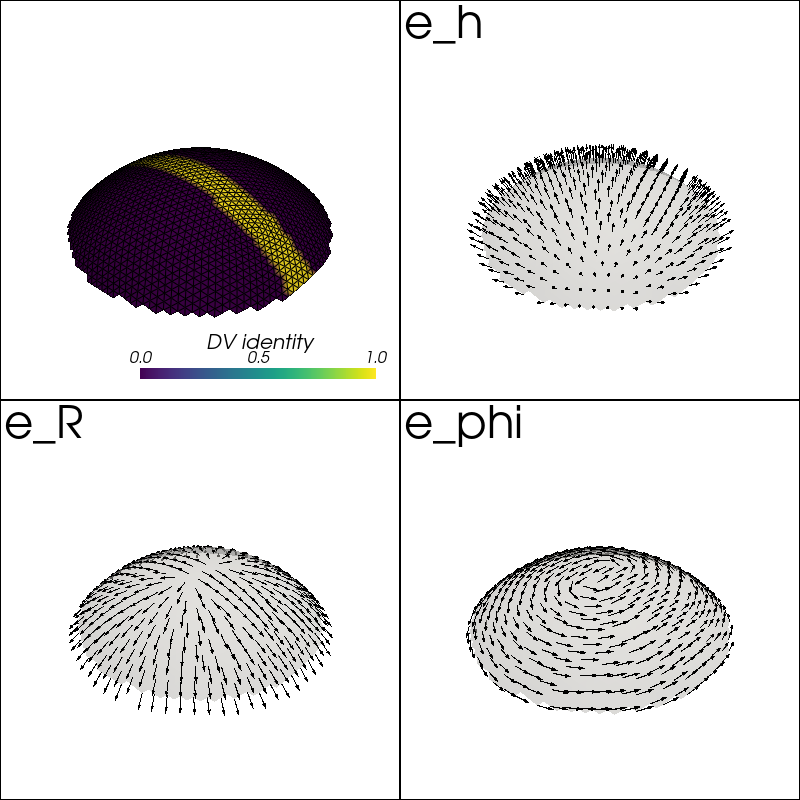

In [10]:
%matplotlib inline

def helper_glyph_subplots(mesh, vector_names, scale_for_vis= 0.1, window_scale = 800, tolerance = 0.03,):
    #display_args = dict(show_edges=True, color=True, line_width= 0.001)
    
    p = pv.Plotter(shape=vector_names.shape, window_size=[vector_names.shape[1]*window_scale, vector_names.shape[0]*window_scale])
    
    def single_plot(i,j,vector_name):
        p.subplot(i,j)
        if vector_name is None: 
            return p
        mesh["vector_scaled"] = mesh[vector_name]*scale_for_vis
        mesh.set_active_vectors("vector_scaled")
        arrows = mesh.glyph(scale="vector_scaled", orient="vector_scaled", tolerance=tolerance)
        p.add_mesh(arrows, lighting=False,show_scalar_bar=False, color = "black",)
        #p.add_mesh(surf.arrows, lighting=False,show_scalar_bar=False,)
        p.add_mesh(mesh, color="grey", ambient=0.6, opacity=0.5, show_edges=False)
        p.add_text(vector_name, color = "black")

    for i in range(vector_names.shape[0]):
        for j in range(vector_names.shape[1]):
            single_plot(i,j,vector_names[i,j])
            
    return p

# put the vector names in the matrix form of how you would like the subplots
vector_names = np.matrix([[None, "e_h"],
                          ["e_R", "e_phi"]
                         ])
p = helper_glyph_subplots(mesh, vector_names, scale_for_vis= 0.1, window_scale = 400, tolerance = 0.03)

#We left the top left plot empty
#We add just the mesh coloring it by a scalar like the identity of DV boundary
p.subplot(0,0)
sargs = dict(
    title_font_size=20,
    label_font_size=16,
    background_color = "gray",
    color = "black",
    shadow=True,
    n_labels=3,
    italic=True,
    fmt="%.1f",
    font_family="arial",
    title = 'DV identity',
)
mesh.set_active_scalars("DV_bool")
p.add_mesh(mesh, show_edges=True,scalar_bar_args=sargs,interpolate_before_map=False, opacity=1)
p.background_color = "white"
p.show(screenshot='test.png') #saving does not seem to work


/Users/absingh/git/topospam/Topo_env/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


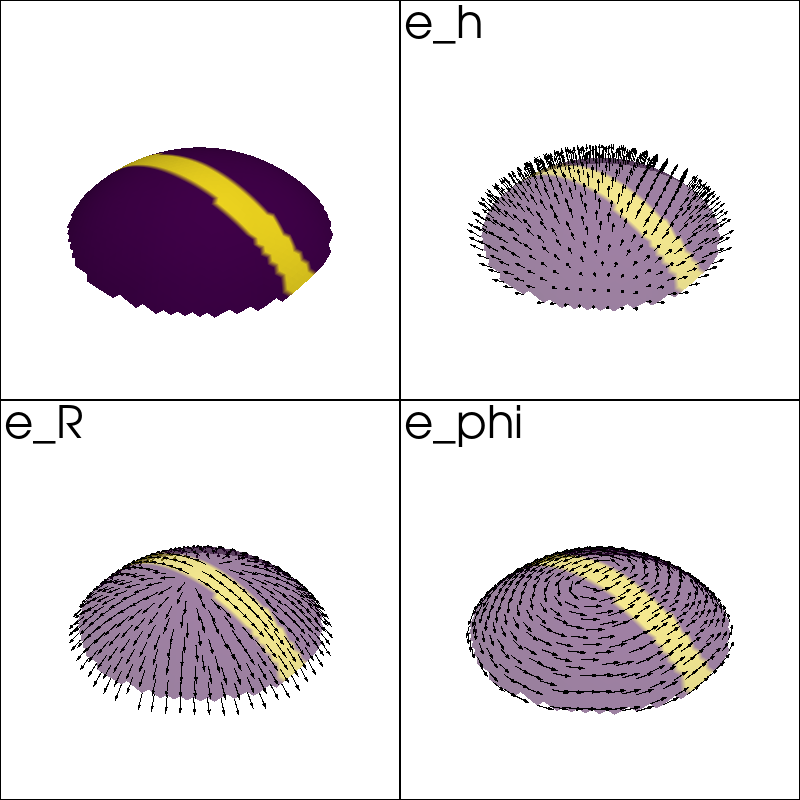

In [11]:
%matplotlib inline

def helper_glyph_subplots(mesh, vector_names, scale_for_vis= 0.1, window_scale = 800, tolerance = 0.03,):
    #display_args = dict(show_edges=True, color=True, line_width= 0.001)
    
    p = pv.Plotter(shape=vector_names.shape, window_size=[vector_names.shape[1]*window_scale, vector_names.shape[0]*window_scale])
    
    def single_plot(i,j,vector_name):
        p.subplot(i,j)
        if vector_name is None: 
            return p
        mesh["vector_scaled"] = mesh[vector_name]*scale_for_vis
        mesh.set_active_vectors("vector_scaled")
        arrows = mesh.glyph(scale="vector_scaled", orient="vector_scaled", tolerance=tolerance)
        p.add_mesh(arrows, lighting=False,show_scalar_bar=False, color = "black",)
        #p.add_mesh(surf.arrows, lighting=False,show_scalar_bar=False,)
        #p.add_mesh(mesh, color="grey", ambient=0.6, opacity=0.5, show_edges=False)
        mesh.set_active_scalars("DV_bool")
        p.add_mesh(mesh, show_edges=False,show_scalar_bar=False,#scalar_bar_args=sargs,
                   interpolate_before_map=False, opacity=0.5)
        p.add_text(vector_name, color = "black")

    for i in range(vector_names.shape[0]):
        for j in range(vector_names.shape[1]):
            single_plot(i,j,vector_names[i,j])
            
    return p

# put the vector names in the matrix form of how you would like the subplots
vector_names = np.matrix([[None, "e_h"],
                          ["e_R", "e_phi"]
                         ])
p = helper_glyph_subplots(mesh, vector_names, scale_for_vis= 0.1, window_scale = 400, tolerance = 0.03)

#We left the top left plot empty
#We add just the mesh coloring it by a scalar like the identity of DV boundary
p.subplot(0,0)
sargs = dict(
    title_font_size=20,
    label_font_size=16,
    background_color = "gray",
    color = "black",
    shadow=True,
    n_labels=3,
    italic=True,
    fmt="%.1f",
    font_family="arial",
    title = 'DV identity',
)
mesh.set_active_scalars("DV_bool")
p.add_mesh(mesh, show_edges=False,show_scalar_bar=False, #scalar_bar_args=sargs,
           interpolate_before_map=False, opacity=1)
p.background_color = "white"
p.show(screenshot='test.png') #saving does not seem to work


/Users/absingh/git/topospam/Topo_env/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


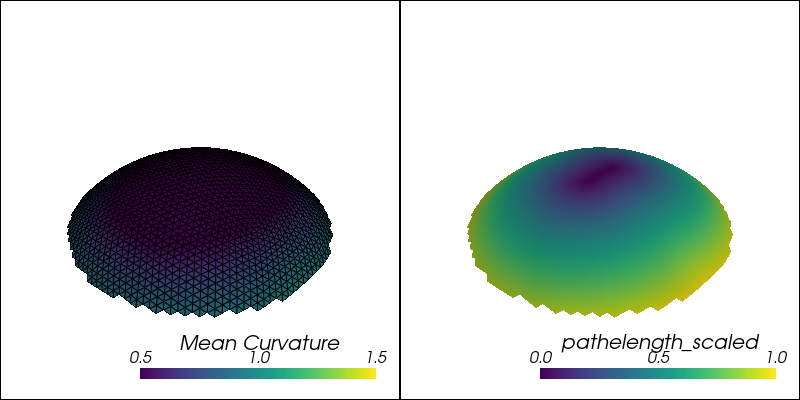

In [12]:
window_scale = 400
sargs = dict(
    title_font_size=20,
    label_font_size=16,
    background_color = "gray",
    color = "black",
    shadow=True, vertical = False, #height=0.25, position_x=0.05, position_y=0.05
    n_labels=3,
    italic=True,
    fmt="%.1f",
    font_family="arial",
    title = "Mean Curvature",
)

p = pv.Plotter(shape=(1,2), window_size=[2*window_scale, window_scale])

#mean curvature
p.subplot(0,0)
mesh.set_active_scalars("mean_curv")
p.add_mesh(mesh, clim=[0.5, 1.5], show_edges=True,scalar_bar_args=sargs,interpolate_before_map=False, opacity=1)
p.background_color = "white"

#gaussian curvature
p.subplot(0,1)
#mesh.set_active_scalars("gauss_curv")
mesh.set_active_scalars("pathlength_scaled")
sargs["title"] = "pathelength_scaled"
p.add_mesh(mesh, clim=[0, 1], show_edges=False, scalar_bar_args=sargs,interpolate_before_map=False, opacity=1)
p.background_color = "white"

p.show()#screenshot='plots/test.png')


/Users/absingh/git/topospam/Topo_env/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


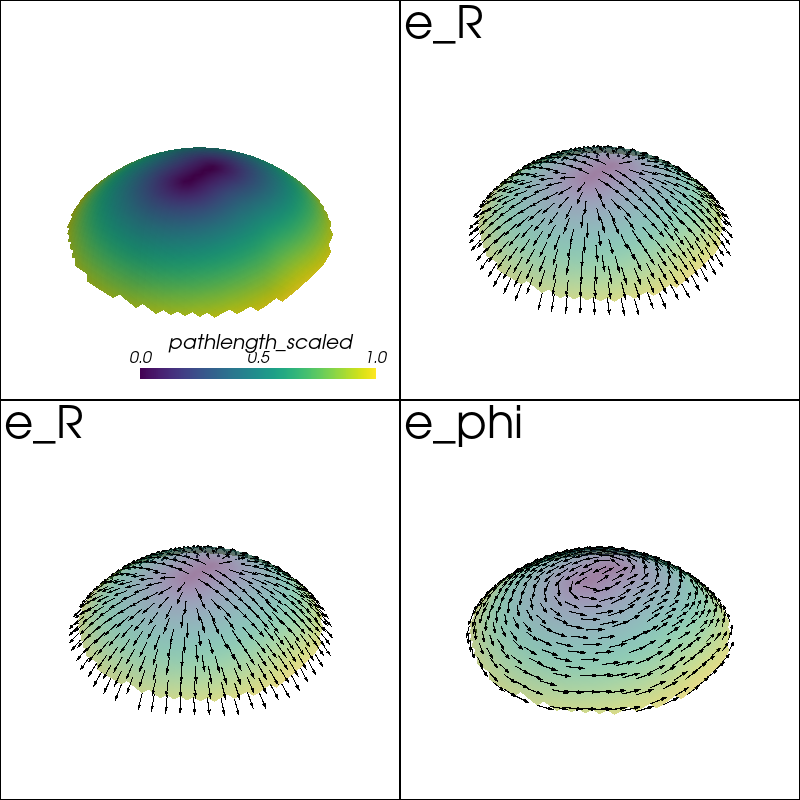

In [13]:
%matplotlib inline

def helper_glyph_subplots(mesh, vector_names, scale_for_vis= 0.1, window_scale = 800, tolerance = 0.03,):
    #display_args = dict(show_edges=True, color=True, line_width= 0.001)
    
    p = pv.Plotter(shape=vector_names.shape, window_size=[vector_names.shape[1]*window_scale, vector_names.shape[0]*window_scale])
    
    def single_plot(i,j,vector_name):
        p.subplot(i,j)
        if vector_name is None: 
            return p
        mesh["vector_scaled"] = mesh[vector_name]*scale_for_vis
        mesh.set_active_vectors("vector_scaled")
        arrows = mesh.glyph(scale="vector_scaled", orient="vector_scaled", tolerance=tolerance)
        p.add_mesh(arrows, lighting=False,show_scalar_bar=False, color = "black",)
        #p.add_mesh(surf.arrows, lighting=False,show_scalar_bar=False,)
        #p.add_mesh(mesh, color="grey", ambient=0.6, opacity=0.5, show_edges=False)
        mesh.set_active_scalars("pathlength_scaled")
        p.add_mesh(mesh, show_edges=False,show_scalar_bar=False,#scalar_bar_args=sargs,
                   interpolate_before_map=False, opacity=0.5)
        p.add_text(vector_name, color = "black")

    for i in range(vector_names.shape[0]):
        for j in range(vector_names.shape[1]):
            single_plot(i,j,vector_names[i,j])
            
    return p

# put the vector names in the matrix form of how you would like the subplots
vector_names = np.matrix([[None, "e_R"],
                          ["e_R", "e_phi"]
                         ])
p = helper_glyph_subplots(mesh, vector_names, scale_for_vis= 0.1, window_scale = 400, tolerance = 0.03)

#We left the top left plot empty
#We add just the mesh coloring it by a scalar like the identity of DV boundary
p.subplot(0,0)
sargs = dict(
    title_font_size=20,
    label_font_size=16,
    background_color = "gray",
    color = "black",
    shadow=True,
    n_labels=3,
    italic=True,
    fmt="%.1f",
    font_family="arial",
    title = 'pathlength_scaled',
)
mesh.set_active_scalars("pathlength_scaled")
p.add_mesh(mesh, show_edges=False,show_scalar_bar=True, scalar_bar_args=sargs,
           interpolate_before_map=False, opacity=1)
p.background_color = "white"
p.show(screenshot='test.png') #saving does not seem to work


## Mesh size 

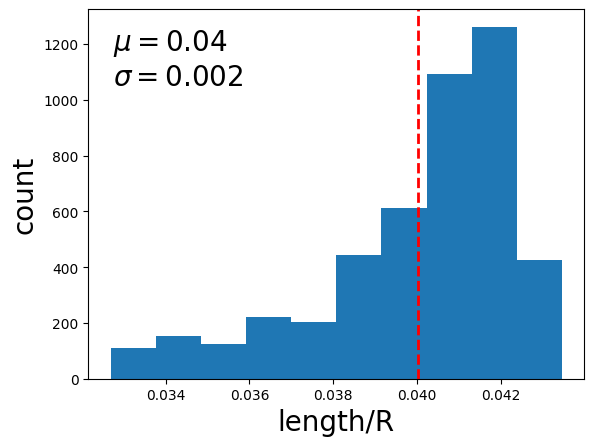

average length of springs in the top layer:  0.04001714759454151
We scale by a factor of 77.66 um
average scaled length of springs in the top layer:  3.1077316821920933
average scaled std in length of springs in the top layer:  0.18209749291778027


In [14]:
fig, ax = plt.subplots()
ax.hist(top_springs.l0);
ax.set_xlabel("length/R", fontsize = 20)
ax.set_ylabel("count", fontsize = 20)
#plot a vertical line at the mean
ax.axvline(top_springs.l0.mean(), color='red', linestyle='dashed', linewidth=2)
#add a text box showing the mean
textstr = '\n'.join((
    r'$\mu=%.2f$' % (top_springs.l0.mean(), ),
    r'$\sigma=%.3f$' % (top_springs.l0.std(), )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top')
plt.show()

print("average length of springs in the top layer: ", top_springs.l0.mean())
print("We scale by a factor of 77.66 um" )
print("average scaled length of springs in the top layer: ", top_springs.l0.mean()*77.66)
print("average scaled std in length of springs in the top layer: ", top_springs.l0.std()*77.66)
